In [1]:
%cd ..

/home/dani2442/Projects/TrafficFlow


/home/dani2442/Projects/TrafficFlow/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import networkx as nx

In [3]:
V_0 = 50 # Desired speed (km/h)
T = 1.2/3600 # Time gap (h)
rho_max = 120 # Maximum density (veh/km)

l_eff = 1/rho_max # Inverse of the minimum distance headway
rho_C = 1/(V_0*T + l_eff) # Critical value between free traffic and congested traffic
C = 1/(T + l_eff/V_0)

@jax.jit
def Q_e(rho):
    return jnp.maximum(0, jnp.where(rho<=rho_C, V_0*rho, (1-rho*l_eff)/T))

In [4]:
x_0, x_N = 0, 100
N_x = 11
T_sim = 4
N_t = 1000
I = 1.0

dx = (x_N - x_0)/(N_x)
dt = T_sim/N_t

In [5]:
def generate_converge():
    G = nx.DiGraph()
    G.add_nodes_from([i for i in range(N_x)] + [-i for i in range(1, N_x+1)])
    G.add_edges_from([(i,i+1) for i in range(N_x-1)] + [(-i-1, -i) for i in range(1,N_x)] + [(-1, int(N_x/2))])

    pos = {i: (i, 0) for i in range(N_x)} | {-i: (int(N_x/2), -i) for i in range(1, N_x+1)}
    return G, pos

def generate_diverge():
    G = nx.DiGraph()
    G.add_nodes_from([i for i in range(N_x)] + [-i for i in range(1, N_x+1)])
    G.add_edges_from([(i+1,i) for i in range(N_x-1)] + [(-i, -i-1) for i in range(1,N_x)] + [(int(N_x/2), -1)])

    pos = {i: (-i, 0) for i in range(N_x)} | {-i: (-int(N_x/2), -i) for i in range(1, N_x+1)}
    return G, pos

def generate_continuous():
    G = nx.DiGraph()
    G.add_nodes_from([i for i in range(N_x)])
    G.add_edges_from([(i,i+1) for i in range(N_x-1)])

    pos = {i: (i, 0) for i in range(N_x)}
    return G, pos

In [20]:
def init_converge(G):
    xs = jnp.linspace(x_0, x_N, N_x)
    for i,j in G.edges:
        if i<0:
            rho = rho_max/4
        else:
            rho = rho_max/4 #+ jnp.exp(-jnp.square((xs[i] - x_N/1.5)/20))*rho_max/2
        G.edges[i, j]['rho_old'] = rho
        G.edges[i, j]['Q_old'] = Q_e(rho)
        G.edges[i, j]['I'] = 1.

    return G

def init_continuous(G):
    xs = jnp.linspace(x_0, x_N, N_x)
    for i,j in G.edges:
        rho = rho_max/4
        #rho = rho_max/4 + jnp.exp(-jnp.square((xs[i] - x_N/2)/20))*rho_max/2
        G.edges[i, j]['rho_old'] = rho
        G.edges[i, j]['Q_old'] = Q_e(rho)

        if i==int(N_x/1.5) or i+1==int(N_x/1.5):
            G.edges[i, j]['I'] = .01
        else:
            G.edges[i, j]['I'] = 1.    
    return G

In [21]:
def plot_graph(G, pos, ax, title=''):
    weights = [float(G.edges[e]['rho_old']) for e in G.edges()]
    # Normalize the weights for colormap
    #norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
    norm = plt.Normalize(0, 120)

    ax.set_title(title)
    # Create the colormap
    cmap = plt.cm.viridis
    nx.draw_networkx_edges(G, pos, node_size=0, arrowstyle='-', width=5, edge_color=weights, edge_cmap=cmap, ax=ax, edge_vmin = 0, edge_vmax=120)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, ax=ax)

In [22]:
@jax.jit
def g_godunov(u, v): 
    mi = jnp.minimum(Q_e(u), Q_e(v))
    ma = jnp.maximum(Q_e(u), Q_e(v))
    return jnp.where(u<=v, mi, ma)

@jax.jit
def g_godunov_post(u, v):
    mi = jnp.minimum(u, v)
    ma = jnp.maximum(u, v)
    return jnp.where(u/I_u<=v/I_v, mi, ma)

In [25]:
def CTM_step(G, verbose=False):
    for i, j in G.edges:
        rho_k = G.edges[i, j]['rho_old']
        I_k = G.edges[i, j]['I']

        edges_in_i = G.in_edges(i, data=True)
        edges_out_j = G.out_edges(j, data=True)

        edges_in_j = G.in_edges(j, data=True)
        edges_out_i = G.out_edges(i, data=True)

        if len(edges_in_i)==0 or len(edges_out_j)==0:
            rho_k_m1_i = 0
            rho_k_p1_i = 0
            Q_up = 0.
            Q_down = 0.
        else:
            u, v, w = 0., 0., 0.
            v = I_k*Q_e(rho_k/I_k)

            I_u, I_v, I_w = 0, I_k, 0
            u_local, v_local, w_local = 0, rho_k, 0
            for edge in edges_in_i:
                data_k_m1_i = edge[2]
                rho_k_m1_i = data_k_m1_i['rho_old']
                I_k_m1_i = data_k_m1_i['I']
                I_u += I_k_m1_i
                u += I_k_m1_i*Q_e(rho_k_m1_i/I_k_m1_i)
                u_local += rho_k_m1_i

            for edge in edges_out_j:
                data_k_p1_i = edge[2]
                rho_k_p1_i = data_k_p1_i['rho_old']
                I_k_p1_i = data_k_p1_i['I']
                I_w += I_k_p1_i
                w += I_k_p1_i*Q_e(rho_k_p1_i/I_k_p1_i)
                w_local += rho_k_p1_i


            u/=len(edges_out_i)
            #w/=len(edges_in_j) 

            u_local/=len(edges_out_i)
            #w_local/=len(edges_in_j)

            mi = jnp.minimum(u, v)
            ma = jnp.maximum(u, v)
            Q_up = jnp.where(u_local<=v_local, mi, ma)

            #if verbose:
            #    print(i,j, 'Q_up: ', Q_up, 'Q_down: ', Q_down)
            #    print(i,j, 'u_local: ', u_local, 'v_local: ', v_local, 'mi: ', mi, 'ma: ', ma)

            mi = jnp.minimum(v, w)
            ma = jnp.maximum(v, w)
            Q_down = jnp.where(v_local<=w_local, mi, ma)

            
        rho_k = rho_k - dt/dx*(Q_down - Q_up)

        print(i,j, rho_k)
        G.edges[i, j]['rho_new'] = rho_k

    for e in G.edges():
        G.edges[e]['rho_old'] = G.edges[e]['rho_new']
    
    return G

In [26]:
G, pos = generate_continuous()
G = init_continuous(G)
CTM_step(G, True)

0 1 30.0
1 2 30.0
2 3 30.0
3 4 30.0
4 5 30.0
5 6 30.66
6 7 30.0
7 8 30.0
8 9 29.34
9 10 30.0


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[]

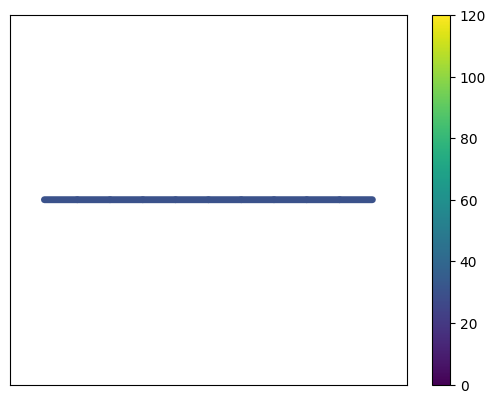

In [10]:
G, pos = generate_continuous()
G = init_continuous(G)

fig, ax = plt.subplots()
plot_graph(G, pos, ax)
plt.plot()

In [11]:
G = init_continuous(G)
G_checkpoints = []

for t_i in range(N_t+1):
    G = CTM_step(G)
    if t_i%200 == 0:
        G_checkpoints += [G.copy()]

[]

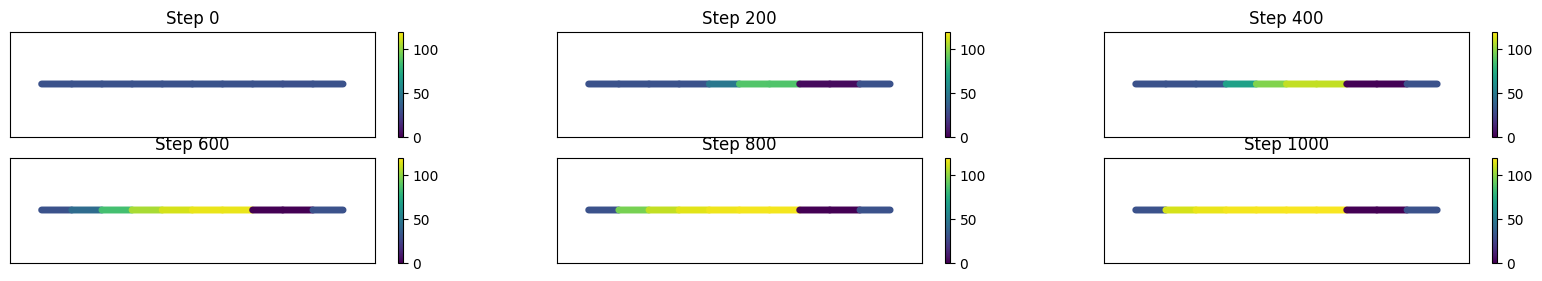

In [12]:
f, axs = plt.subplots(2, len(G_checkpoints)//2, figsize=(20,3))
for i, ax in enumerate(axs.reshape(-1)):
    plot_graph(G_checkpoints[i], pos=pos, ax=ax, title=f'Step {i*200}')

plt.plot()

[]

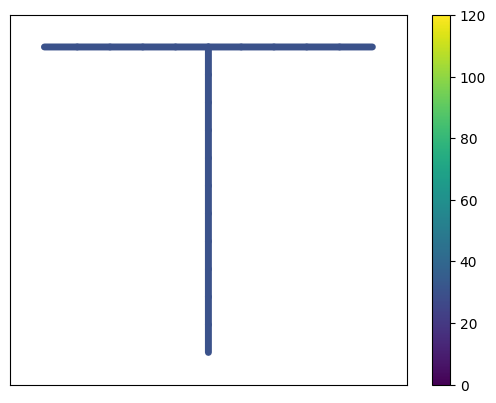

In [13]:
G, pos = generate_converge()
G = init_converge(G)

fig, ax = plt.subplots()
plot_graph(G, pos, ax, '')
plt.plot()

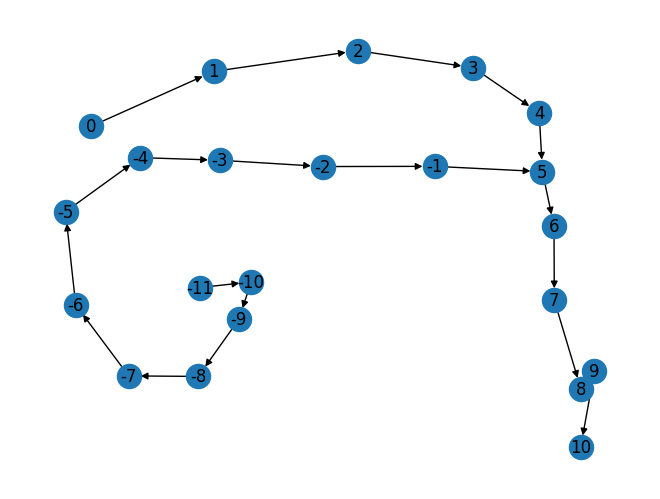

In [14]:
nx.draw(G, pos=nx.spring_layout(G), with_labels=True)

In [15]:
G = init_converge(G)
G_checkpoints = []

for t_i in range(N_t):
    G = CTM_step(G)
    if t_i%50 == 0:
        G_checkpoints += [G.copy()]

[]

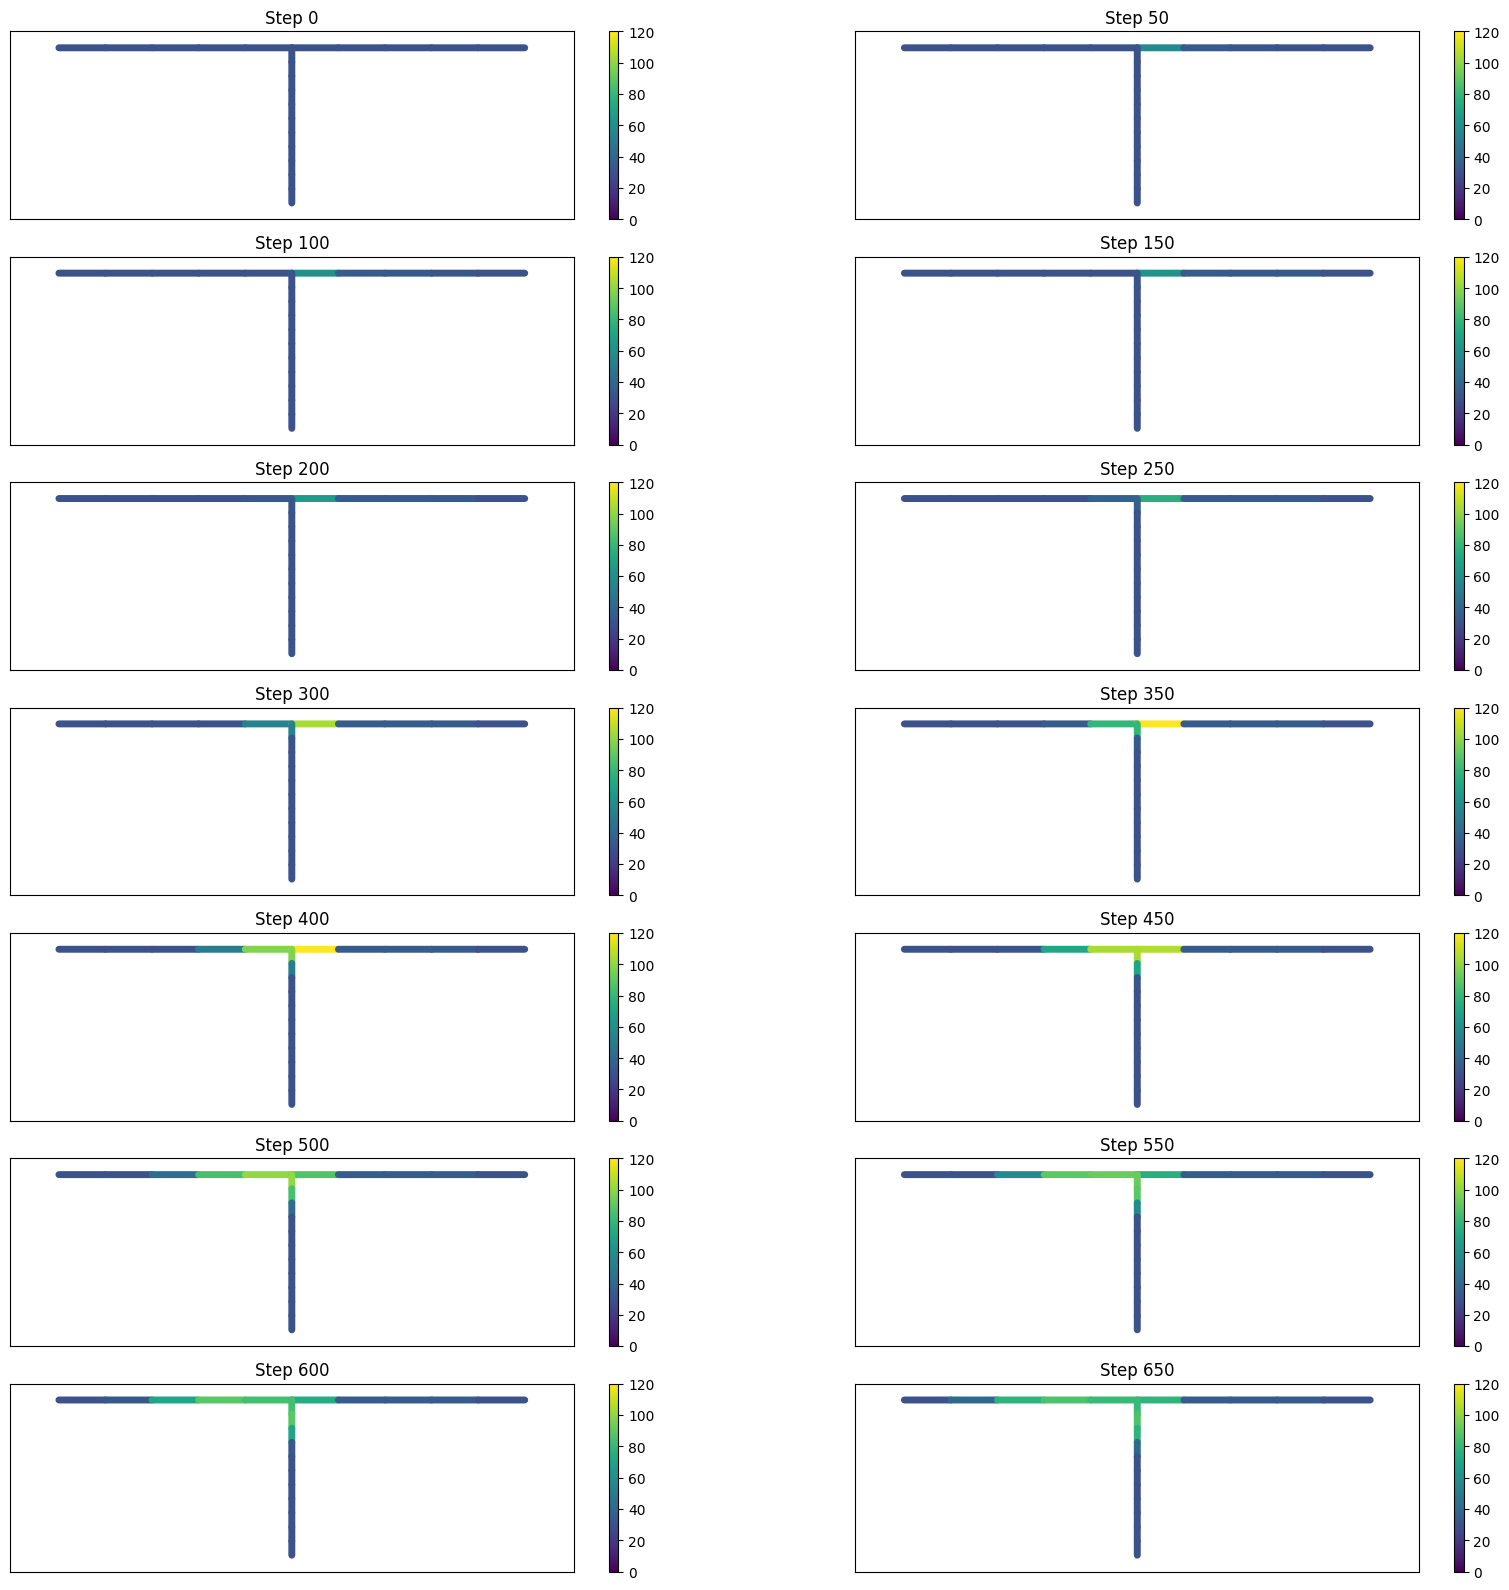

In [16]:
f, axs = plt.subplots(7, 2, figsize=(20,20))
for i, ax in enumerate(axs.reshape(-1)):
    plot_graph(G_checkpoints[i], pos=pos, ax=ax, title=f'Step {i*50}')

plt.plot()

# 1. Diverging

In [17]:
""" G = nx.DiGraph()

G.add_nodes_from([0,1,2,3,4,5])
G.add_edges_from([(0,1), (1,2), (2, 3), (3, 4), (2, 5), (5, 6)])

pos = {0: (0,0), 1:(1, 0), 2: (2,0), 3: (3, 1), 4: (4, 2), 5: (3,-1), 6: (4, -2)}

nx.draw(G, pos, with_labels=True, font_weight='bold') """

" G = nx.DiGraph()\n\nG.add_nodes_from([0,1,2,3,4,5])\nG.add_edges_from([(0,1), (1,2), (2, 3), (3, 4), (2, 5), (5, 6)])\n\npos = {0: (0,0), 1:(1, 0), 2: (2,0), 3: (3, 1), 4: (4, 2), 5: (3,-1), 6: (4, -2)}\n\nnx.draw(G, pos, with_labels=True, font_weight='bold') "

[]

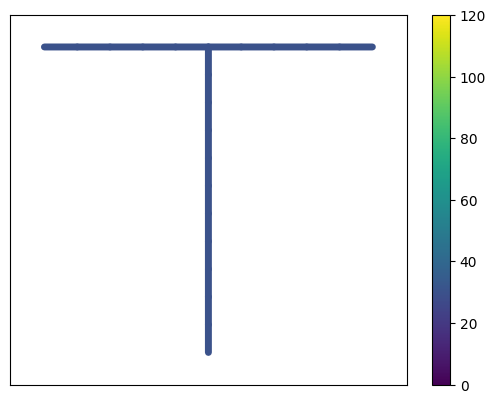

In [18]:
G, pos = generate_diverge()
G = init_converge(G)

fig, ax = plt.subplots()
plot_graph(G, pos, ax, '')
plt.plot()

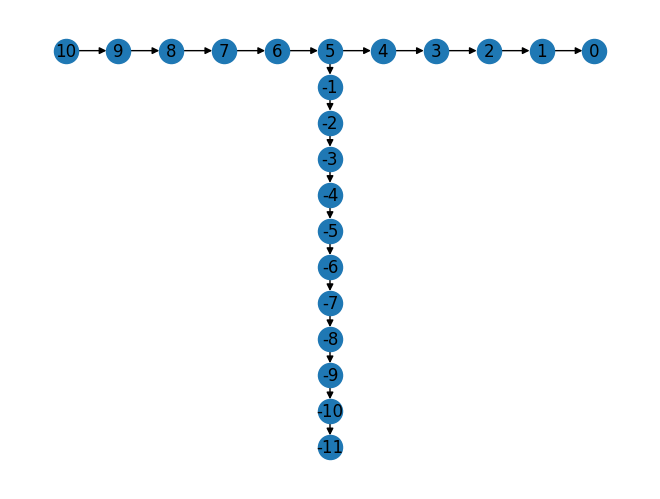

In [19]:
nx.draw(G, pos=pos, with_labels=True)

In [20]:
G = init_converge(G)
G_checkpoints = []

for t_i in range(N_t):
    G = CTM_step(G)
    if t_i%50 == 0:
        G_checkpoints += [G.copy()]

[]

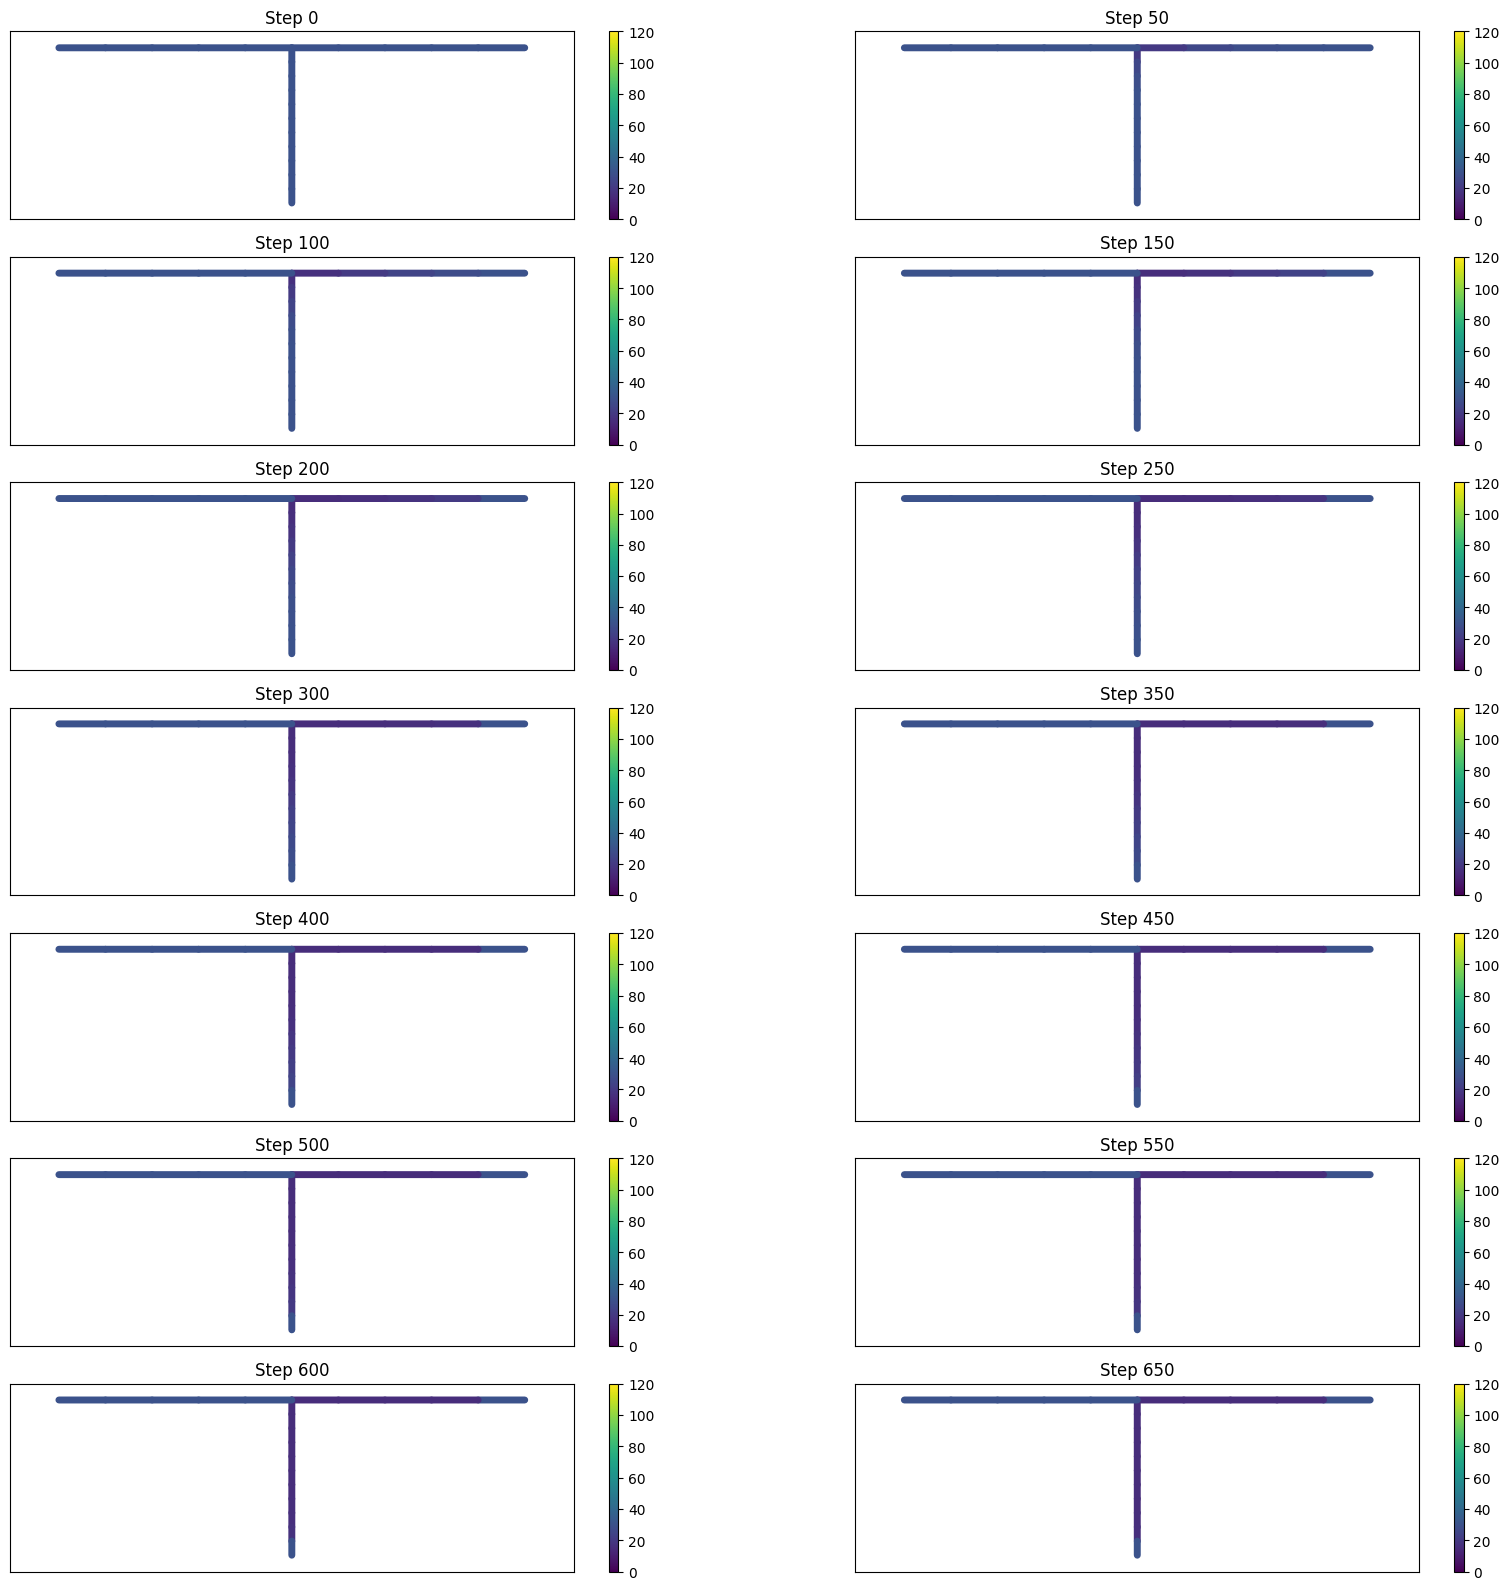

In [21]:
f, axs = plt.subplots(7, 2, figsize=(20,20))
for i, ax in enumerate(axs.reshape(-1)):
    plot_graph(G_checkpoints[i], pos=pos, ax=ax, title=f'Step {i*50}')

plt.plot()